In [1]:
import os
from os.path import join
from pathlib import Path
cur_dir = Path(os.getcwd())
par_dir = cur_dir.parent.absolute()

import sys
import time
import numpy as np
import pickle as pkl
import tensorflow as tf
import scipy.sparse as sps

sys.path.append(str(par_dir))
from utils import *
from tensorflow.python.saved_model import tag_constants
from models import scGCN
# sys.stdout = open(str(cur_dir.joinpath('PBMC_lr=0.05_eps=50_outputs.txt')), "w")

import warnings
warnings.filterwarnings("ignore")
#' del_all_flags(FLAGS)

# Set random seed
seed = 123
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
tf.set_random_seed(seed)

In [2]:
# Settings
exp_id = 'MCAOS'
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('f', '', 'kernel')  # to run in jupyter kernels
flags.DEFINE_string('dataset', join(str(par_dir), f'input/{exp_id}'), 'data dir')
flags.DEFINE_string('output', join(str(cur_dir), f'{exp_id}_results'), 'predicted results')
flags.DEFINE_bool('graph', True, 'select the optional graph.')
flags.DEFINE_string('model', 'scGCN','Model string.') 
flags.DEFINE_float('learning_rate', 0.05, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
#flags.DEFINE_integer('hidden2', 32, 'Number of units in hidden layer 2.')
flags.DEFINE_float('dropout', 0, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10,
                     'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

# output flow
# sys.stdout = open(str(cur_dir.joinpath(f'{exp_id}_outputs.txt')), "w")

In [4]:
# Load data
adj, features, labels_binary_train, labels_binary_val, labels_binary_test, train_mask, pred_mask, val_mask, test_mask, new_label, true_label, index_guide = load_data(
    FLAGS.dataset,rgraph=FLAGS.graph)

support = [preprocess_adj(adj)]
num_supports = 1
model_func = scGCN

# Define placeholders
placeholders = {
    'support':
    [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features':
    tf.sparse_placeholder(tf.float32,
                          shape=tf.constant(features[2], dtype=tf.int64)),
    'labels':
    tf.placeholder(tf.float32, shape=(None, labels_binary_train.shape[1])),
    'labels_mask':
    tf.placeholder(tf.int32),
    'dropout':
    tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero':
    tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask,
                                        placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

load data succesfully....
tr.shape=(97137, 2000), va.shape=(1781, 2000), te.shape=(1981, 2000)
Constructing adjaceny graph
assign input coordinatly....






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [5]:
# Initialize session
sess = tf.Session()
# Init variables
sess.run(tf.global_variables_initializer())

train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []
test_accuracy = []
test_loss = []

# Train model

#configurate checkpoint directory to save intermediate model training weights
saver = tf.train.Saver()
save_dir = str(cur_dir.joinpath(f'{exp_id}_checkpoints/'))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'best_validation')

for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, labels_binary_train,
                                    train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy],
                    feed_dict=feed_dict)
    train_accuracy.append(outs[2])
    train_loss.append(outs[1])
    # Validation
    cost, acc, duration = evaluate(features, support, labels_binary_val,
                                   val_mask, placeholders)
    val_loss.append(cost)
    val_accuracy.append(acc)
    test_cost, test_acc, test_duration = evaluate(features, support,
                                                  labels_binary_test,
                                                  test_mask, placeholders)
    test_accuracy.append(test_acc)
    test_loss.append(test_cost)
    saver.save(sess=sess, save_path=save_path)
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=",
          "{:.5f}".format(outs[1]), "train_acc=", "{:.5f}".format(outs[2]),
          "val_loss=", "{:.5f}".format(cost), "val_acc=", "{:.5f}".format(acc),
          "time=", "{:.5f}".format(time.time() - t))
    if epoch > FLAGS.early_stopping and val_loss[-1] > np.mean(
            val_loss[-(FLAGS.early_stopping + 1):-1]):
        print("Early stopping...")
        break

print("Finished Training....")

Epoch: 0001 train_loss= 2.94418 train_acc= 0.04209 val_loss= 2.87325 val_acc= 0.56429 time= 7.30488
Epoch: 0002 train_loss= 2.87322 train_acc= 0.56953 val_loss= 2.74360 val_acc= 0.60472 time= 7.11837
Epoch: 0003 train_loss= 2.74350 train_acc= 0.60511 val_loss= 2.56365 val_acc= 0.60415 time= 7.35681
Epoch: 0004 train_loss= 2.56341 train_acc= 0.60479 val_loss= 2.34621 val_acc= 0.60303 time= 7.65380
Epoch: 0005 train_loss= 2.34573 train_acc= 0.60442 val_loss= 2.11598 val_acc= 0.60359 time= 7.28199
Epoch: 0006 train_loss= 2.11515 train_acc= 0.60285 val_loss= 1.90602 val_acc= 0.60303 time= 7.22644
Epoch: 0007 train_loss= 1.90475 train_acc= 0.59922 val_loss= 1.74318 val_acc= 0.60135 time= 7.19601
Epoch: 0008 train_loss= 1.74155 train_acc= 0.59841 val_loss= 1.62319 val_acc= 0.60135 time= 7.17355
Epoch: 0009 train_loss= 1.62144 train_acc= 0.60141 val_loss= 1.51782 val_acc= 0.60303 time= 7.68740
Epoch: 0010 train_loss= 1.51627 train_acc= 0.60398 val_loss= 1.40985 val_acc= 0.60415 time= 7.30652


In [6]:
all_mask = np.array([True] * len(train_mask))
labels_binary_all = new_label

feed_dict_all = construct_feed_dict(features, support, labels_binary_all,
                                    all_mask, placeholders)
feed_dict_all.update({placeholders['dropout']: FLAGS.dropout})

activation_output = sess.run(model.activations, feed_dict=feed_dict_all)[1]
predict_output = sess.run(model.outputs, feed_dict=feed_dict_all)

#' accuracy on all masks
ab = sess.run(tf.nn.softmax(predict_output))
all_prediction = sess.run(
    tf.equal(sess.run(tf.argmax(ab, 1)),
             sess.run(tf.argmax(labels_binary_all.astype("int32"), 1))))

#' accuracy on prediction masks 
acc_train = np.sum(all_prediction[train_mask]) / np.sum(train_mask)
acc_test = np.sum(all_prediction[test_mask]) / np.sum(test_mask)
acc_val = np.sum(all_prediction[val_mask]) / np.sum(val_mask)
acc_pred = np.sum(all_prediction[pred_mask]) / np.sum(pred_mask)
print('Checking train/test/val set accuracy: {}, {}, {}'.format(
    acc_train, acc_test, acc_val))
print('Checking pred set accuracy: {}'.format(acc_pred))

Checking train/test/val set accuracy: 0.993485342019544, 0.98334174659263, 0.9859629421673217
Checking pred set accuracy: 0.5361142251733951


In [7]:
acc_pred, acc_train, acc_val

(0.5361142251733951, 0.993485342019544, 0.9859629421673217)

In [8]:
src_label = pd.read_csv(join(FLAGS.dataset, 'Label1.csv'))['type'].values
tgt_label = pd.read_csv(join(FLAGS.dataset, 'Label2.csv'))['type'].values

In [9]:
tgt_shr_mask = np.in1d(tgt_label, np.unique(src_label))

In [10]:
all_pr = np.argmax(ab, axis=1)
all_gt = np.argmax(labels_binary_all.A, axis=1)

In [13]:
from metrics import osr_evaluator

E_score = pd.read_csv(join(FLAGS.dataset, 'sample_E_score.csv'))
H_score = pd.read_csv(join(FLAGS.dataset, 'sample_H_score.csv'))

E_score = E_score.x.replace(float('-inf'), 0).values
H_score = H_score.x.replace(float('-inf'), 0).values

open_score = H_score - E_score

kn_data_pr = all_pr[pred_mask][tgt_shr_mask]
kn_data_gt = all_gt[pred_mask][tgt_shr_mask]
kn_data_open_score = open_score[tgt_shr_mask]

unk_data_open_score = open_score[np.logical_not(tgt_shr_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)
closed_acc, os_auroc, os_aupr, oscr

close_acc= 0.7456
AUROC= 0.3604
AUPR= 0.2537
OSCR= 0.3269


(0.7456004725257543,
 0.36037378135749065,
 0.2536540916308957,
 0.3268653482680932)

In [16]:
pred_label = sess.run(tf.argmax(ab, 1))
pred_prob = sess.run(tf.reduce_max(ab, 1))
gt_label   = sess.run(tf.argmax(labels_binary_all.astype('float'), 1))
id2label = dict(zip(gt_label[~pred_mask], true_label[~pred_mask].to_numpy().ravel()))
pred_type = np.array([id2label[_] for _ in pred_label])

import scanpy as sc
adata = sc.AnnData(predict_output[pred_mask])
adata.obs['pred_type'] = pred_type[pred_mask]
adata.obs['cell_type'] = true_label[pred_mask].to_numpy().ravel()
adata.obs['pred_prob'] = pred_prob[pred_mask]
adata.obs['share_mask'] = tgt_shr_mask

... storing 'pred_type' as categorical
... storing 'cell_type' as categorical


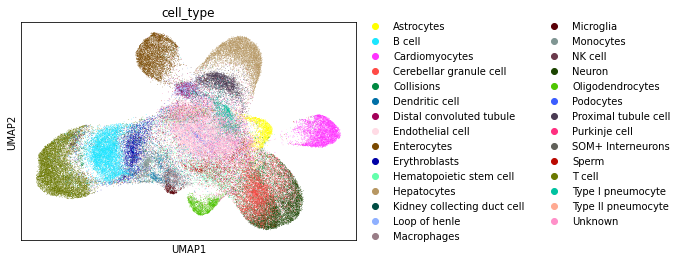

In [18]:
import umap

reducer = umap.UMAP(n_neighbors=15,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
embedding = reducer.fit_transform(adata.X)
adata.obsm["X_umap"] = embedding

sc.pl.umap(adata, color=['cell_type'])